# Implementation of Multiple Interval LGR 

This example demonstrates using Legendre-Gauss-Radau (LGR) points with multiple intervals to calculate the integral and the derivative of a known polynomial function. Everything is working as expected.

In [1]:
using NLOptControl
using Polynomials
using Plots
using FastGaussQuadrature
pyplot()

Plots.PyPlotBackend()


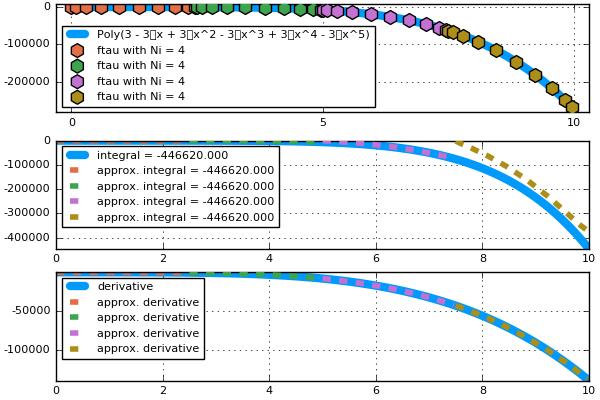

/home/febbo/.julia/v0.5/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [2]:
# define problem
t0 = Float64(0); tf = Float64(10);  # TODO change and y to x
t = Array(linspace(t0,tf,100));
α₁ =  3; α₂ = -3; α₃ = -8; α₄ =  7;
Nc = Int64(10); # number of collocation points in each interval
Ni = Int64(4); # number of intervals
####################################
# perform analytical calcualtions
####################################
γ = Poly([α₁,α₂,α₁,α₂,α₁,α₂]); #TODO check on that imported binding warning
y = polyval(γ,t)

# evaluate the integral
∫γ = polyint(γ);
Y = polyval(∫γ,t[end]) - polyval(∫γ,t[1]);
C = Y - polyval(∫γ,t[end]); # constant of integration
∫y = polyval(∫γ,t) + C;

# evaluate the derivative
dγ = polyder(γ);
dy = polyval(dγ,t);

####################################
# construct polynomial approximation
####################################
τ, ω = gaussradau(Nc); # number of collocation points per interval

# break the problem up into multiple intervals
function create_intervals(t0::Float64,tf::Float64,Ni::Int64,Nc::Int64,τ::Vector{Float64},ω::Vector{Float64})
  di = (tf - t0)/Ni # interval size
  # create mesh points
  tm = zeros(Float64,Ni+1); tm[1] = t0;
  for idx in 1:Ni
    tm[idx+1] = tm[idx] + di;
  end
  # go through each mesh interval creating time intervals; [t(i-1),t(i)] --> [-1,1]
  ts = zeros(Float64,Nc,Ni);  ωₛ = zeros(Float64,Nc,Ni);
  for idx in 1:Ni
    # scale the problem to the interval
    ts[:,idx] = scale_tau(τ,tm[idx],tm[idx+1]); # scale the interval
    ωₛ[:,idx] = scale_w(ω,tm[idx],tm[idx+1]);   # scale the weights
  end
  return di, tm, ts, ωₛ
end

di, tm, ts, ωₛ = create_intervals(t0,tf,Ni,Nc,τ,ω)

#TODO check integral matrix

# approximate the integral
ζ = zeros(Float64,Nc,Ni); fτ = zeros(Float64,Nc,Ni);approx_int = Float64(0);
for idx in 1:Ni
  fτ[:,idx] = polyval(γ,ts[:,idx]);
  ζ[:,idx] =  cumsum(ωₛ[:,idx].*fτ[:,idx],1)
  approx_int = approx_int + ζ[end,idx];
end
# approximate the derivative --> needed in defect constraints
dζ = zeros(Float64,Nc,Ni);
for idx in 1:Ni
  D = poldif(ts[:,idx], 1)
  dζ[:,idx] = D*fτ[:,idx]
end

#################
# post processing
#################
fp=plot(0,leg=:false)
plot!(t,y,label=string(γ),w=6)
scatter!(ts,fτ,label=string("ftau with Ni = ",Ni),markershape = :hexagon, markersize=10)

dp=plot(0,leg=:false)
plot!(t,dy,label="derivative",w=6)
plot!(ts,dζ,label="approx. derivative",line=(4,:dash))

ip=plot(0,leg=:false)
plot!(t,∫y,label=@sprintf("integral = %0.3f",∫y[end]),w=6)
plot!(ts,ζ,label=@sprintf("approx. integral = %0.3f",approx_int),line=(4,:dash))

plot(fp,ip,dp,layout=(3,1))

In [3]:
savefig("test1a.png")

# Increase Polynomial Order to 3

In [7]:
savefig("test1b.png")

# 

In [9]:
savefig("test3c.png")

# 

In [11]:
savefig("test1d.png")

In [17]:
savefig("test3e.png")